# Continuous Control in Reacher with DDPG - Report
____________

## Introduction
This is my submission report for Project 2 (Continuous Control) of Udacity's Deep Reinforcement Learning Nanodegree. In this project, we train an agent in a Unity environment to control a double-jointed arm and reach for a moving target. This is a task with a 33-dimensional continuous state space and 4-dimensional action space. I chose to implement DDPG in order to solve the **single-agent** version of the task.

### Background & overview of Actor-Critic and DDPG
In [Project 1](https://github.com/andrefmsmith/drlnd_NavigationSubmission/blob/master/Report.ipynb) we saw how deep neural networks could be used as function approximators for arriving at an estimate of Q, the action-value function. In particular, we implemented a [Deep Q Network (DQN)](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf). DQNs learn to evaluate policies by minimizing a loss between predicted and target Q values. DQNs were an important advance in DRL research since they improved upon two big problems of using deep neural networks for action-value function approximation, which meant this approach was previously too unstable: i) the **correlation between trajectories** experienced by the agent (by using Replay Buffers), and  ii) the problem of **moving targets** when using the same network to estimate a value and setting a target for learning (by using fixed Q targets). Deep value-based approaches mainly work with discrete action spaces, since the policy is arrived by using the argmax operator over action values. This makes them unwieldy for high-dimensional and/or continuous action spaces.  

In subsequent lectures, we saw how it was actually possible to maximise the optimization objective of returns over time directly, by using **policy gradient** approaches such as [REINFORCE](https://github.com/andrefmsmith/amsRL_openAIgym/blob/master/Pong/CodeBlog_PongFromPixels_2.0.ipynb). In this and more advanced policy gradient approaches, agents learn policies directly, without the need to estimate value functions, by performing gradient ascent on the expected return function and tweaking parameters to produce actions that lead to high returns with increased probability. Policy gradient approaches are useful because policies can be any learnable function, including continuous and stochastic action spaces. Moreover, they can have better convergence properties, since action probabilities change smoothly as a function of learned parameters as opposed to aggressively due to the use of argmax in value-based approaches. However, policy gradient approaches have high variance because we use full Monte-Carlo returns to calculate gradients, compounding the randomness and variability of trajectories under the same policy.  

**Actor-Critic** methods are an attempt to get the best of both worlds by using an estimate of the action-value or advantage function instead of actual return to reduce the variance of policy gradients. In AC approaches we use two neural networks: an **Actor** learns the policy and a **Critic** learns a value function. The value function estimated by the critic is used to train the Actor instead of the total returns, which reduces variance and can lead to faster learning.  

**[DDPG](https://arxiv.org/abs/1509.02971)** is an Actor-Critic method (according to some) which, similar to DQN, uses a replay buffer to train an action-value function and target networks to stabilize training. Differently to DQN, it learns a policy directly with an Actor network, which approximates the optimal action and can learn a deterministic policy in continuous action spaces. The subtle difference between DQN and DDPG is that whereas the former uses the target Q-function for retrieving the greedy action using argmax, DDPG uses a target deterministic policy function that is *trained to approximate* that greedy action. 

## DDPG Agent & Methods
______________________
### Algorithm overview
1. Define an **online** and a **target** instance for the **Actor** and **Critic** networks. Actor networks are *states in, actions out* whereas Critic networks are *states in, single action value out*. However, because they estimate the Q value for a given action, Critic networks need to be *fed an action as well as the state*. This happens at their first hidden layer.
2. At every timestep, feed the state into the online Actor network in order to return the greedy action according to the current policy.
    - To enable exploration, add scaled noise from a normal distribution to this output and clip the result to the boundaries of the action space. As training proceeds, scale this noise down.
3. Store the timestep's state, performed action, reward, next state and terminal flag in the agent's replay buffer.
4. If the number of timesteps stored has completed a batch, and if a pre-defined number of timesteps have passed since the last update epoch, run an optimization step.
5. Optimization step:
    - Retrieve k (batch size) experience tuples from the replay buffer;
    - Calculate targets:
        - Query the **Actor target** network for the best actions to perform in the next states
        - Feed these actions and states to the **Critic target** network thus obtaining their Q value
        - Compute Q targets by adding observed rewards and discounting the Q values of the next states (computed above)
    - Compute the expected Q value for current states and actions by querying the **Critic online** network
    - Compute **loss for the online critic network** by using mean square error between expected and target Q value
    - Compute the current policy's best action by querying the **online Actor** network
    - Compute **loss for the online actor network** by evaluating the value of the current policy's best action with the online critic network
        - Use the negative of the loss, so that optimization **maximises** the value of actions outputted by the policy network
6. Update the target networks by blending the online and target network weights according to a tau-parameterised weighted average, thus ensuring the target network is changing at a much slower rate than the online and producing stable targets.
    

### Define Actor and Critic network architectures

Here we define classes for the Actor and Critic architectures, which we'll call on later when setting up our Agent for DDPG. **Actor** is a *'state-in action-out'* network with one hidden layer.
```Python
class Actor(nn.Module):
    def __init__(self, state_size, action_size, hu=(400, 300), activ_in = F.relu, activ_out = torch.tanh):
        super(Actor, self).__init__()
        
        self.activ_in = activ_in
        self.activ_out = activ_out
        
        self.input_layer = nn.Linear(state_size, hu[0])
        self.hl1 = nn.Linear(hu[0], hu[1])
        self.output_layer = nn.Linear(hu[-1], action_size)
        
    def forward(self, state):
        x = state
        x = self.activ_in(self.input_layer(x))
        x = self.activ_in(self.hl1(x))
        return self.activ_out(self.output_layer(x)) 
        ```
The input layer size matches the state size and the output layer size matches the action space. In our forward method, we use ReLu for inner layer activations and tanH for output because the boundaries for our action space are [-1, 1]. If they were higher, we would need to scale them appropriately. I tried deeper networks but training was significantly slower.  


**Critic** is a *'state-in Q value-out'* network with one hidden layer. We want this network to learn how to approximate the Q value of a specific action and to achieve this, it needs to know both the state and the action.
```Python
class Critic(nn.Module):
    def __init__(self, state_size, action_size, hu=(400, 300), activ_in = F.relu):
        super(Critic, self).__init__()
        
        self.activ_in = activ_in
        
        self.input_layer = nn.Linear(state_size, hu[0])
        self.hl1 = nn.Linear(hu[0]+action_size, hu[1])        
        self.output_layer = nn.Linear(hu[-1], 1)
        
    def forward(self, state, action):
        x = state
        u = action
        
        x = self.activ_in(self.input_layer(x))
        x = torch.cat((x, u), dim=1)
        x = self.activ_in(self.hl1(x))
        return self.output_layer(x)```
The input layer matches state size. However, at the first hidden layer we add a number of units equal to the action size, so that during forward propagation we can feed this network an action so that it can use state and action information to approximate a Q value in its output. The action size is small enough (4-dimensional) that it requires less processing and transformation thatn the state. I imagine with a higher action size we may want to feed it to the input layer. As we wish the Critic to learn how to approximate the action value of a single action, the output size is 1 and requires no activation function.

### The Agent's attributes
In addition to state size and action size I set up my agent to take in a number of noise-related arguments, which we will use for exploratory actions later on:
```Python
class Agent():
    def __init__(self, state_size, action_size, start_noise=SN, noise_decay=ND, noise_min=NM, add_noise=True):```
We make use of our previously-defined Actor and Critic classes to create an online and a target network for each. We also set up two separate optimizers as we may want the learning rate for Actor and Critic to be different:
```Python
        ### Initialise actor online and target networks
        self.actor_online = Actor(state_size, action_size).to(device)
        self.actor_target = Actor(state_size, action_size).to(device)
        self.actor_optimizer = optim.Adam(self.actor_online.parameters(), lr=LR_ACTOR)
        
        ### Initialise critic online and target networks
        self.critic_online = Critic(state_size, action_size).to(device)
        self.critic_target = Critic(state_size, action_size).to(device)
        self.critic_optimizer = optim.Adam(self.critic_online.parameters(), lr=LR_CRITIC)```

In addition, we initialise the previously-mentioned noise parameters, a memory that instantiates an object of class ReplayBuffer (to be defined later) and an update attribute which will keep track of how many timesteps have occurred since we ran an optimization step:
```Python
        ### Noise parameters for exploration
        self.noise_scale = start_noise
        self.noise_decay = noise_decay
        self.noise_min = noise_min
        
        self.add_noise = add_noise
        
        ### Replay buffer
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE)
        
        ### Keep track of timesteps since last training update
        self.update = 0```

### The Agent's methods

**Generating noise for exploratory actions**  
I chose a simple strategy for setting up an exploration schedule for the agent. I define a function that generates noise and updates the noise's scale over time by calling on the Agent's noise attributes which are defined at initialization:
```Python
    def generate_noise(self):
        noise = np.random.normal(loc=0, scale=self.noise_scale, size=self.action_size)
        self.noise_scale = max(self.noise_decay*self.noise_scale, self.noise_min)
        return noise```
The numpy method np.random.normal(loc, scale, size) returns a 'size' number of floats drawn from a normal distribution with mean 'loc' and standard deviation 'scale'. The action space in this task spans [-1, 1] so we want this normal distribution to be centered at 0 (loc=0). I use the Agent's noise_scale attribute as standard deviation and return a number of floats equal to action size. Alternatively, I could have returned a single random float to be added to each entry in the action vector. I felt the former seemed more robust, since it would build up independence in the outputs of the policy network for each entry in the action vector. After generating noise, the 'generate_noise' function progresses by updating the Agent's internal 'noise_scale' attribute according to an exponential schedule, with constant defined by agent attribute 'noise_decay'. A minimum amount of noise 'noise_min' is kept throughout, to ensure a baseline level of exploration. I feel this is also a form of regularization and ensuring representation robustness, in the sense that since random noise is always added to the agent's output, this helps attenuate parameter overfitting.  

**Controlling the Agent's progression**  
We need a method for controlling the agent's progression through time. The 'step' method stores fresh experiences in the replay buffer and triggers an optimization epoch if appropriate:
```Python
def step(self, state, action, reward, next_state, done, update_cycles=3):
        # Commit experience to memory
        self.memory.add(state, action, reward, next_state, done)
        self.update = (self.update +1)%update_every
        
        # Run optimisation 'update_cycles' times
        c=0
        if (self.update==0):
            if len(self.memory) > BATCH_SIZE:
                while c < update_cycles:
                    experiences = self.memory.sample()
                    self.learn(experiences, GAMMA)
                    c+=1```
Experience tuples are added to the replay buffer using it's method 'add' (to be defined later) and then the agent updates how many time steps have passed since it ran an optimization cycle. The amount of timesteps to wait before optimization is controlled by hyperparameter 'update_every'. If this number has been reached *and* a full batch of timesteps has elapsed (controlled by hyperparameter 'BATCH_SIZE'), the agent will sample experience tuples from memory (.sample method of replay buffer class, to be defined) and run an optimization sequence on them. This will happen inside a 'while' loop, so that the agent samples experiences and learns an 'update_cycles' number of times from them.  

**Selecting actions and exploring**  
The agent will use its online Actor network to output a greedy action:
```Python
    def act(self, state):
        state = torch.from_numpy(state).float().to(device)
        self.actor_online.eval()
        with torch.no_grad():
            action = self.actor_online(state).cpu().data.numpy()
        self.actor_online.train()
        if self.add_noise:
            action += self.generate_noise()
        return np.clip(action, -1, 1)```
To ensure exploration, if we have set the Agent's 'add_noise' attribute to True, the 'act'function calls on 'generate_noise', and adds the output of this method to the Agent's action, updating also its noise schedule. The function return clips this action to the boundaries of the action space [-1, 1] in case they have been exceeded by the adding of noise.  

**Updating the Agent**  
Finally, we have a function for performing parameter updating. **First**, this function unpacks the experience tuples sampled from the replay buffer into individual tensors:
```Python
def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences```
        
**Second**, it updates the Critic network. To achieve this, it must set optimization targets by estimating returns from the current state, computing the loss between target and online estimates and backpropagate it to update parameters. We do this in the following steps:
1. Query the target Actor network for the actions to be performed in the next states;
2. Query the target Critic network for the estimated value of these future actions;
3. Compute a learning target for the value of the current action by discounting future action values and adding to them observed rewards;
4. Query the online Critic network for its estimate of value for the action;
5. Compute the mean square error loss between the online Critic's expectation and the target Critic's learning target; and finally,
6. Backpropagate and clip the gradient to stabilize learning.

```Python
        ### Update critic
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        Q_targets = rewards + (gamma * Q_targets_next * (1-dones))
        Q_expected = self.critic_online(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Backprop
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_online.parameters(), 1)
        self.critic_optimizer.step()```  

**Third**, we update the Actor network. This involves:
1. Querying the online Actor for its predicted best action;
2. Passing this action and the states to the online critic network to query its value;
3. Using the *negative* of this as loss, given our goal is to maximise the value of actions chosen by the Actor network. Herein lines the key difference between policy gradient and AC approaches: in the former we obtained a Monte-Carlo estimate of the total returns and we maximised that function using gradient ascent. In the latter, we use a Critic network to estimate action value instead;
4. We backpropagate this loss and once again clip the gradient to promote stability.

```Python
        ### Update actor
        actions_pred = self.actor_online(states)
        actor_loss = -self.critic_online(states, actions_pred).mean()
        # Backprop
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.actor_online.parameters(), 1)
        self.actor_optimizer.step()```  
        
**Finally** we must update our target networks:
```Python
    def soft_update(self, online_model, target_model, tau):
        for target_param, online_param in zip(target_model.parameters(), online_model.parameters()):
            target_param.data.copy_(tau*online_param.data + (1.0-tau)*target_param.data)```
Here we are not using fixed Q targets as such, given that we don't 'freeze' the target networks' parameters as we did for DQNs where target networks were frozen for 10,000 timesteps, before having their parameters overwritten by a copy of the online networks'. All we need to prevent moving targets is for the online networks approximating functions and the target networks generating learning targets to be in different states. We ensure that by using a hyperparameter 'tau' as a weighting factor for averaging the online and target networks' parameters. This effectively means that target networks lag behind their online counterparts at a very slow timescale (since we'll typically set tau to a 3-4 digit fractional number), but they are also being updated at the same rate. 

### The ReplayBuffer class
The ReplayBuffer has a 'memory' container for storing experience tuples and a series of methods to interact with them. 
```Python
class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
    
    ### Adds an experience tuple to memory
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)```
The 'memory' container is a deque, meaning once 'maxlen' capacity is reached it behaves as latest one in, oldest one out. We also configure a series of class attributes. In particular 'experience' is set up as an namedtuple object, which makes retrieving and organising experiences in 'memory' easier.  

We commit experiences to memory using the **add** method, which takes arguments for all the elements of an experience, formats them as a tuple as defined by the 'experience' namedtuple class then adds them at the latest slot of the 'memory' deque.  


Finally, experiences are sampled from memory for learning by using the **sample** method:
```Python
    ### Samples k (batch size) experience tuples randomly from memory
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        
        return (states, actions, rewards, next_states, dones)```
This simply draws a k number of experiences from the memory container (controlled by hyperparameter 'batch_size'), unpacks them into individual tensors so they can be fed to a neural network, and sends them to the training device. The batch sample is returned as a tuple of tensors for convenience.

______________________
## Training the agent
The 'ddpg' function trains the agent for a number of timesteps 'max_t' over a number of episodes 'n_episodes', saving checkpoints named 'output' for Actor and Critic networks if the environment has been solved:
```Python
def ddpg(output, n_episodes=1000, max_t=1000):```
It keeps track of performance in the last 100 episodes which makes it easier to assess if the solving criteria has been reached, as well as score per episode, which is the only variable that it returns upon completion:
```Python
    scores_deque = deque(maxlen=100)
    scores = []```
The function runs an episode and timestep loop with the correct syntax for Unity environments. 'max_t' is set to a default of 1,000 timesteps which is the episode length for Reacher.
```Python
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]           # reset the environment 
        state = env_info.vector_observations[0]                     # get the current state
        score = 0                                                   # initialize the score
        for t in range(max_t):
            action = agent.act(state)                               # select an action
            env_info = env.step(action)[brain_name]                 # send action to tne environment
            next_state = env_info.vector_observations[0]            # get next state
            reward = env_info.rewards[0]                            # get reward
            done = env_info.local_done[0]                           # check if episode finished
            agent.step(state, action, reward, next_state, done)     # agent takes one step to train
            state = next_state                                      # roll over state to next time step
            score += reward                                         # update the score
            if done:                                                # exit loop if episode finished
                break```
Scores are kept track of and printed for monitoring purposes and if the solving criteria of mean score > 30.0 over the latest 100 episodes (checked as mean of the 100-episode-long deque), the episode loop is broken and checkpoints saved for Actor and Critic networks, with the prefix defined by function argument 'output':
```Python
        scores_deque.append(score)
        scores.append(score)
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, np.mean(scores_deque), score), end="")
        if np.mean(scores_deque)>=30.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            torch.save(agent.actor_online.state_dict(), '{}_checkpoint_actor.pth'.format(output))
            torch.save(agent.critic_online.state_dict(), '{}_checkpoint_critic.pth'.format(output))
            break```

## Hyperparameters
I will comment on the hyperparameters which I found most effective to experiment with.   

**Buffer & Batch Size** In practise, I found a higher batch size (1024) seemed to work best in this environment. It has a relatively complex (33-d) and continuous state space, which suggests the variability between trajectories could be large. Therefore it makes sense that the agent might have to perform a large number of episodes in order to obtain performance representative of the particular policy it's currently under. With this in mind, given Reacher episodes are 1,000 timesteps, it was necessary to increase the buffer size to accomodate this elevated batch size.  
```Python
BUFFER_SIZE = int(3e6)     # replay buffer size
BATCH_SIZE = 1024          # minibatch size```

**Learning rates for Actor and Critic** I found a slightly higher learning rate for the critic tended to work best.  
```Python
LR_ACTOR = 1e-4            # learning rate of the actor 
LR_CRITIC = 2e-4           # learning rate of the critic```

**Update every** In early attempts I updated the network more frequently. Similar to suggested in the exercise setup, this didn't work particularly well. In my winning submission, once a batch has been completed, the agent updates itself 3 times every 20 timesteps.
```Python
update_every = 20          # number of timesteps after which to run an update```

**Starting Noise, Noise Decay and Noise Minimum** Since DDPG is a deterministic policy approach, we need to make sure the agent explores, especially at the beginning, in order to learn a good policy. In my implementation I do this by drawing noise from a normal distribution with mean 0 and standard deviation equal to 'noise scale', then adding this noise to the action output. I elected to choose a not too high value for the noise scale, to prevent the output getting clipped too often to -1 or 1, which would defeat the point of exploration. Throughout training, we would like the agent to reduce its exploratory actions. My strategy was to decrease the noise scale exponentially (by multiplying it every timestep by a decay constant 'noise decay') down to a noise floor of 'noise minimum'. This ensure the agent retained a certain degree of exploration throughout the whole training schedule. This may also help with the robustness of learnt representations and generalization.
```Python
SN = 0.25                  # starting value for additive noise scale (exploratory actions)
ND = 0.99999               # noise decay rate (exploratory actions)
NM = 0.01                  # noise minimum to be maintained (exploratory actions)```

_______________
## Submission results

The agent solved the environment in 365 episodes, having achieved an
average score of 30.04.  
<img align="left" src="Final_score.png"/>

______________________
## Ideas for future improvement
**Prioritizing Experiences** The random sampling of the Replay Buffer when training seems to work fine but I would improve upon it by prioritizing those experiences where the difference between online and target Q values was highest. This would involve some rewriting of the code, since the loss function would also be affected. The reason for this is that in a correct implementation of Prioritized Experience Replay, experiences need to be weighted in proportion to their likelihood of occurring, otherwise the agent may overfit to very informative but rare experiences. The idea of Prioritized Experience Replay appeals a lot to me due to its biological inspiration: in the brain, experiences are tagged by their emotional content and abundant evidence suggests replay in the mammalian brain during sleep is scaled by this parameter.  

**Exploration Schedule** The agent's score is very low for the 200 first episodes, showing a steep and sudden improvement between 200 and 300, and another bump in improvement rate after episode 300. Below, I plotted the noise scale used in my schedule at each episode number for generating exploratory actions. There is an uncanny match between the stage in noise scale below and rate of score improvement above. The agent's performance in the first 200 episodes overlaps with a period of fairly high noise scale, which may be masking the agent's 'true potential' in the task ie, it is already *capable* of achieving a higher score its current actions suffer from having too much additive noise. Granted, it is this period of early exploration which *enables* the agent to navigate the task's high-dimensional parameter structure and eventually arrive at a good policy, but I wonder if alternative noise schedules (linear decrease, periodic such as a sine function with decreasing amplitude see below) would lead to faster learning. Explore/exploit dynamics in real-world biological agents are not monotonic however; many animals instead switch between 'perform' and 'play' modes, at least when the situation is not threatening to survival. 

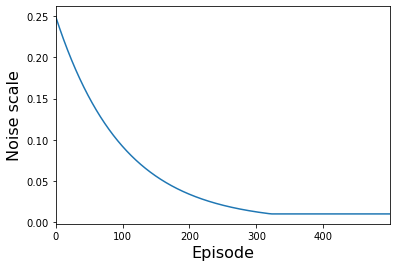

In [15]:
import matplotlib.pyplot as plt
import math
plt.plot([max(0.01, 0.25*0.99999**t) for t in range(1000000)]);
plt.xlim((0,500000));
plt.xticks(range(0,500000,100000), labels=range(0,500,100));
plt.xlabel('Episode', size=16);
plt.ylabel('Noise scale', size=16);

## Each episode is 1,000 timesteps therefore episode number = timestep/1000

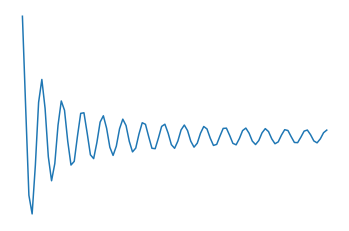

In [48]:
## Example periodic decreasing schedule
plt.plot([1+math.sin(i)*-1/i for i in range(5,100) ]);
plt.axis('off');